Roles: ['TOP', 'MID']
Champions: ['G', 'D', 'A']
Baseline utilities u0[(r,c)]:
  ('MID', 'A'): 9
  ('MID', 'D'): 3
  ('MID', 'G'): 5
  ('TOP', 'A'): 4
  ('TOP', 'D'): 7
  ('TOP', 'G'): 8

=== Baseline min-cost flow solution ===
Optimal cost      : -17
Optimal utility   : 17
Optimal lineup    : {'TOP': 'G', 'MID': 'A'}
Check: utility + cost = 0 (should be 0, since cost=-utility)

=== Parametric analysis results (TOP–A buff) ===
theta=-4, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta=-3, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta=-2, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta=-1, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta= 0, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta= 1, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta= 2, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta= 3, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta= 4, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta= 5, utility=17, lineup={'TOP': 'G', 'MID': 'A'}
theta= 6, utility=17, lineup=

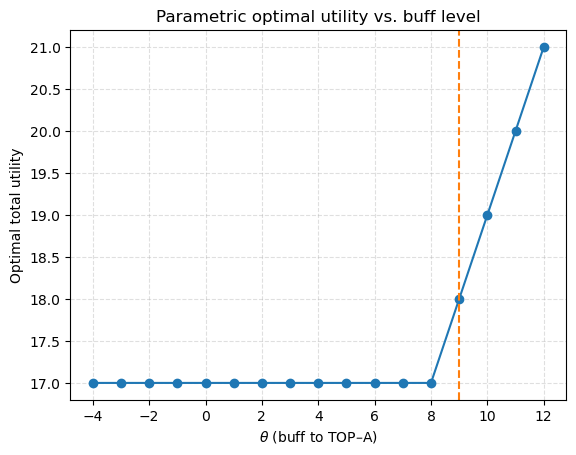

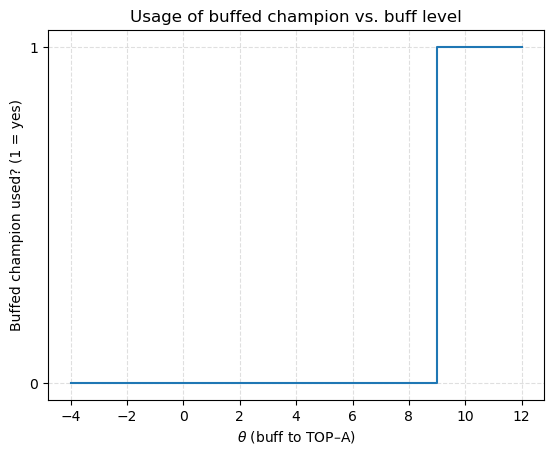

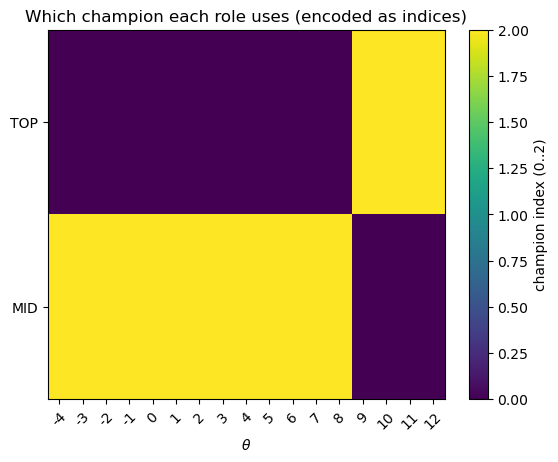

In [1]:
# Required packages: networkx, matplotlib, numpy
#   - networkx: for the min-cost flow solver (networkx.min_cost_flow)
#   - matplotlib: for plotting the figures
#   - numpy: for the heatmap matrix in the last plot

"""
League of Legends ban-pick as a min-cost flow problem
with parametric analysis, using NetworkX as the solver.

Requirements:
    - networkx
    - matplotlib
    - numpy  (only for the heatmap plot)

This script does three main things:

1. Build and solve a min-cost flow model for a single LoL-like
   ban-pick instance (static primal model).

2. Perform parametric analysis by buffing the utility of one
   specific role–champion pair (here: TOP–A) by an amount theta.

3. Produce plots that visualize:
      (a) optimal total utility vs. theta,
      (b) whether TOP uses the buffed champion vs. theta,
      (c) which champion each role picks vs. theta (heatmap).
"""

from __future__ import annotations

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# ---------------------------------------------------------------------
# 1. Problem data: roles, champions, baseline utilities
# ---------------------------------------------------------------------

def create_baseline_instance():
    """
    Create a tiny toy instance consistent with the slides:

        Roles: TOP, MID
        Champions: G, D, A  (you can think of Gnar, Darius, Ahri)

    Utilities u[r, c] are chosen so that:
        - Baseline optimal lineup is (TOP G, MID A) with total utility 17.
        - If we buff TOP–A enough, the optimal lineup switches to (TOP A, MID G).

    Returns
    -------
    roles : list of str
    champions : list of str
    u0 : dict[(role, champ) -> float]
          Baseline utility matrix.
    """
    roles = ["TOP", "MID"]
    champions = ["G", "D", "A"]

    # Utility matrix as a dictionary u0[(role, champ)]
    # (same numbers as in the slides)
    u0 = {
        ("TOP", "G"): 8,
        ("TOP", "D"): 7,
        ("TOP", "A"): 4,
        ("MID", "G"): 5,
        ("MID", "D"): 3,
        ("MID", "A"): 9,
    }

    return roles, champions, u0


# ---------------------------------------------------------------------
# 2. Building and solving the min-cost flow model with NetworkX
# ---------------------------------------------------------------------

def build_lol_min_cost_flow_graph(roles, champions, utilities):
    """
    Build a directed graph for the min-cost flow model using NetworkX.

    Network structure:
        - Nodes:
            R_TOP, R_MID, ...  (role nodes)
            C_G, C_D, C_A, ... (champion nodes)
            t                  (sink node)
        - Demands:
            Each role node R_r has demand = -1 (supplies one unit of flow),
            Sink node t has demand = +|R| (consumes all flow, where |R| is the number of roles),
            Champion nodes have demand = 0.
        - Edges:
            R_r -> C_c  (capacity 1, cost = -u_{r,c})
            C_c -> t    (capacity 1, cost = 0)

    Parameters
    ----------
    roles : list of str
    champions : list of str
    utilities : dict[(role, champ) -> float]
        Utility matrix u_{r,c}.

    Returns
    -------
    G : nx.DiGraph
        Graph ready for networkx.min_cost_flow.
    """
    G = nx.DiGraph()
    num_roles = len(roles)

    # --- Add nodes with demands --------------------------------------
    # Sink node consumes |R| units of flow.
    G.add_node("t", demand=num_roles)

    # Each role node supplies 1 unit of flow.
    for r in roles:
        G.add_node(f"R_{r}", demand=-1)

    # Champion nodes are transshipment nodes (demand = 0).
    for c in champions:
        G.add_node(f"C_{c}", demand=0)

    # --- Add edges: role -> champion ---------------------------------
    for r in roles:
        for c in champions:
            u_rc = utilities[(r, c)]
            cost = -u_rc   # min-cost flow uses "weight" as cost
            G.add_edge(
                f"R_{r}",
                f"C_{c}",
                capacity=1,     # role r can send at most 1 unit to champion c;
                                 # with demand -1 at R_r and integral flow, r picks exactly one champion
                weight=cost
            )

    # --- Add edges: champion -> sink ---------------------------------
    for c in champions:
        G.add_edge(
            f"C_{c}",
            "t",
            capacity=1,     # each champion can appear at most once
            weight=0        # no extra cost on this arc
        )

    return G


def solve_lol_min_cost_flow(G, roles, champions, utilities):
    """
    Solve the min-cost flow model using NetworkX and decode the lineup.

    Parameters
    ----------
    G : nx.DiGraph
        Graph built by build_lol_min_cost_flow_graph.
    roles, champions, utilities : see above.

    Returns
    -------
    cost : float
        Optimal total cost (sum of edge cost * flow).
    total_utility : float
        Optimal total utility = -cost (because we used cost = -utility).
    lineup : dict[role -> champ]
        Mapping of each role to its chosen champion.
    """
    # Compute the minimum-cost flow.
    # flow_dict is a nested dictionary: flow_dict[u][v] = flow on edge u->v.
    flow_dict = nx.min_cost_flow(G)
    cost = nx.cost_of_flow(G, flow_dict)

    # Decode the role->champion decisions:
    lineup = {}
    for r in roles:
        r_node = f"R_{r}"
        for c in champions:
            c_node = f"C_{c}"
            if flow_dict[r_node].get(c_node, 0) > 0:
                lineup[r] = c
                break

    # Compute total utility directly from the lineup.
    total_utility = sum(utilities[(r, c)] for r, c in lineup.items())

    return cost, total_utility, lineup


# ---------------------------------------------------------------------
# 3. Parametric utilities and analysis
# ---------------------------------------------------------------------

def make_parametric_utilities_top_champion(u0, champ_to_buff, theta):
    """
    Create a new utility dictionary u(theta) where only the
    TOP–champion pair (TOP, champ_to_buff) is changed by +theta.

    This matches the example in the slides where we buff TOP–A.

    Parameters
    ----------
    u0 : dict[(role, champ) -> float]
        Baseline utility matrix.
    champ_to_buff : str
        Name of the champion to buff on TOP.
    theta : float
        Buff amount for TOP–champ_to_buff.

    Returns
    -------
    u_theta : dict[(role, champ) -> float]
        Parametrically modified utilities.
    """
    u_theta = {}
    for (r, c), val in u0.items():
        if r == "TOP" and c == champ_to_buff:
            u_theta[(r, c)] = val + theta
        else:
            u_theta[(r, c)] = val
    return u_theta


def run_parametric_analysis(roles, champions, u0, champ_to_buff, theta_values):
    """
    Run parametric analysis over a grid of theta values.

    For each theta:
      - build updated utilities u(theta),
      - build a new graph,
      - solve the min-cost flow problem,
      - record cost, utility, lineup, and whether the buffed champion is used.

    Parameters
    ----------
    roles, champions, u0 : as above
    champ_to_buff : str
        Champion that is buffed on TOP.
    theta_values : list[float]
        Parameter values to test.

    Returns
    -------
    results : list[dict]
        Each dict contains:
            "theta"       : theta value,
            "cost"        : optimal min cost,
            "utility"     : optimal total utility,
            "lineup"      : dict[role -> champ],
            "uses_buffed" : bool, True if the buffed champion is used on TOP.
    """
    results = []

    for theta in theta_values:
        # 1. Build parametric utilities u(theta)
        u_theta = make_parametric_utilities_top_champion(
            u0, champ_to_buff, theta
        )

        # 2. Construct graph and solve min-cost flow
        G_theta = build_lol_min_cost_flow_graph(roles, champions, u_theta)
        cost, util, lineup = solve_lol_min_cost_flow(
            G_theta, roles, champions, u_theta
        )

        # 3. Did we actually use the buffed champion on TOP?
        # If you care about any role (not just TOP), you could instead use:
        # uses_buffed = champ_to_buff in lineup.values()
        uses_buffed = (lineup["TOP"] == champ_to_buff)

        results.append(
            {
                "theta": theta,
                "cost": cost,
                "utility": util,
                "lineup": lineup,
                "uses_buffed": uses_buffed,
            }
        )

    return results


# ---------------------------------------------------------------------
# 4. Plotting functions for parametric analysis
# ---------------------------------------------------------------------

def plot_optimal_utility_vs_theta(results, champ_to_buff):
    """
    Plot optimal total utility as a function of theta.

    Also draw vertical dashed lines at theta values where the
    optimal lineup changes (breakpoints).
    """
    thetas = [r["theta"] for r in results]
    utilities = [r["utility"] for r in results]

    fig, ax = plt.subplots()
    ax.plot(thetas, utilities, marker="o")

    ax.set_xlabel(r"$\theta$ (buff to TOP–%s)" % champ_to_buff)
    ax.set_ylabel("Optimal total utility")
    ax.set_title("Parametric optimal utility vs. buff level")

    # Find where the lineup changes and mark with vertical lines.
    previous_lineup = None
    for r in results:
        if previous_lineup is None:
            previous_lineup = r["lineup"]
            continue
        if r["lineup"] != previous_lineup:
            ax.axvline(r["theta"], linestyle="--", color="tab:orange")
        previous_lineup = r["lineup"]

    ax.grid(True, linestyle="--", alpha=0.4)

    return fig


def plot_buffed_champion_usage(results, champ_to_buff):
    """
    Plot a step function showing whether TOP uses the buffed champion
    as theta varies.

    y = 1  if lineup["TOP"] == champ_to_buff,
      = 0  otherwise.
    """
    thetas = [r["theta"] for r in results]
    used = [1 if r["uses_buffed"] else 0 for r in results]

    fig, ax = plt.subplots()
    ax.step(thetas, used, where="post")

    ax.set_xlabel(r"$\theta$ (buff to TOP–%s)" % champ_to_buff)
    ax.set_ylabel("Buffed champion used? (1 = yes)")
    ax.set_yticks([0, 1])
    ax.set_title("Usage of buffed champion vs. buff level")

    ax.grid(True, linestyle="--", alpha=0.4)

    return fig


def plot_role_champion_heatmap(results, roles, champions):
    """
    Heatmap showing which champion each role picks as theta varies.

    For each theta and each role, we encode the chosen champion by an index:
        index = 0, 1, 2, ... depending on position in `champions` list.

    Then we plot a matrix of shape (num_roles, num_thetas).
    """
    champ_index = {c: i for i, c in enumerate(champions)}
    theta_values = [r["theta"] for r in results]
    n_theta = len(theta_values)
    n_roles = len(roles)

    # Initialize all entries with NaN (will not show in the colormap).
    mat = np.full((n_roles, n_theta), np.nan)

    # Fill matrix with champion indices.
    for j, r in enumerate(results):
        lineup = r["lineup"]
        for i, role in enumerate(roles):
            champ = lineup[role]
            mat[i, j] = champ_index[champ]

    fig, ax = plt.subplots()
    im = ax.imshow(mat, aspect="auto", interpolation="nearest")

    ax.set_yticks(range(n_roles))
    ax.set_yticklabels(roles)

    ax.set_xticks(range(n_theta))
    ax.set_xticklabels(theta_values, rotation=45)
    ax.set_xlabel(r"$\theta$")
    ax.set_title("Which champion each role uses (encoded as indices)")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("champion index (0..%d)" % (len(champions) - 1))

    return fig


# ---------------------------------------------------------------------
# 5. Main script: run everything and show plots
# ---------------------------------------------------------------------

def main():
    # 1. Create baseline instance and solve the static min-cost flow model.
    roles, champions, u0 = create_baseline_instance()

    print("Roles:", roles)
    print("Champions:", champions)
    print("Baseline utilities u0[(r,c)]:")
    for key in sorted(u0.keys()):
        print(f"  {key}: {u0[key]}")

    G0 = build_lol_min_cost_flow_graph(roles, champions, u0)
    cost0, util0, lineup0 = solve_lol_min_cost_flow(G0, roles, champions, u0)

    print("\n=== Baseline min-cost flow solution ===")
    print("Optimal cost      :", cost0)
    print("Optimal utility   :", util0)
    print("Optimal lineup    :", lineup0)
    print("Check: utility + cost =", util0 + cost0, "(should be 0, since cost=-utility)")

    # 2. Parametric analysis: buff TOP–A by theta.
    champ_to_buff = "A"
    theta_values = list(range(-4, 13))  # from -4 to 12 inclusive

    results = run_parametric_analysis(roles, champions, u0,
                                      champ_to_buff, theta_values)

    print("\n=== Parametric analysis results (TOP–A buff) ===")
    for r in results:
        print(
            f"theta={r['theta']:2d}, "
            f"utility={r['utility']:2d}, "
            f"lineup={r['lineup']}"
        )

    # 3. Plots.
    fig1 = plot_optimal_utility_vs_theta(results, champ_to_buff)
    fig2 = plot_buffed_champion_usage(results, champ_to_buff)
    fig3 = plot_role_champion_heatmap(results, roles, champions)

    # Show all figures (useful when running locally).
    plt.show()

    # If you want to save figures for slides, uncomment:
    # fig1.savefig("fig_parametric_utility.png", dpi=300, bbox_inches="tight")
    # fig2.savefig("fig_parametric_usage.png", dpi=300, bbox_inches="tight")
    # fig3.savefig("fig_parametric_heatmap.png", dpi=300, bbox_inches="tight")


if __name__ == "__main__":
    main()
